In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.pyplot import imshow
from PIL import Image
import os

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

torch.__version__

'1.8.0'

# Dataset and DataLoader Class

PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data.

## Dataset class and loading dataset

`Dataset` stores the samples and their corresponding labels.

In [2]:
from torch.utils.data import Dataset, DataLoader
#Forces to give same random number every time it gets compiled
torch.manual_seed(1234)

### Working with torchvision/torch pre-build datasets

Click [here](https://pytorch.org/docs/stable/torchvision/datasets.html) to explore different datasets.

Common parameters across torchvision datasets

1. `root:` the path where the data is stored.
2. `train:` specifies training or test data.
3. `download:` downloads the dataset if not available at root
4. `transform:` feature transformation
5. `target_transform:` label transformation

In [3]:
#function to load the image for display
def show(sample, shape=(28,28)):
    plt.imshow(sample[0].numpy().reshape(shape), cmap='gray')
    plt.title(sample[1])
    plt.axis("off")
    plt.show()

In [4]:
import torchvision.datasets as dsets
from torchvision.transforms import ToTensor

#importing the pre-built mnist dataset
mnist_dataset = dsets.MNIST(root='./../data/',
                           train=False, # If True, creates dataset from training.pt, otherwise from test.pt.
                           download=True, # Downloads if not present at the root location
                           transform = ToTensor())

Each element of the dataset object contains a tuple.

Shape of input image tensor ::  torch.Size([1, 28, 28])
Label id ::  7


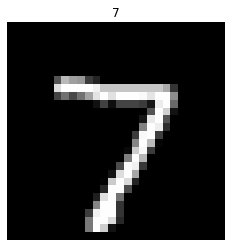

In [5]:
print("Shape of input image tensor :: ", mnist_dataset[0][0].shape)
print("Label id :: ", mnist_dataset[0][1])
show(mnist_dataset[0])

### Working with torchtext pre-built dataset

In [6]:
from torchtext.datasets import IMDB

In [7]:
train_iter = IMDB(root='./../data/IMDB', split='train')
test_iter = IMDB(root='./../data/IMDB', split='test')

Will give an iterator to the dataset

In [8]:
train_data = []
for label, line in train_iter:
    train_data.append((label, line))
    
test_data = []
for label, line in test_iter:
    test_data.append((label, line))

In [9]:
sample_idx = torch.randint(len(train_data), size=(1,)).item()
label, line = train_data[sample_idx]
print(sample_idx, '\t', line, '\t', label)

19775 	 Along with "King of the Rocket Men", this was still being repeated on BBC TV in the early to mid eighties. If I was loading up a time capsule of this period both these series would definitely go in.<br /><br />Someone watching it for the first time will think it is silly but this is one of the best examples of the "Serials". Don Del Oro will make you laugh (When I was little my nickname for him was Mr Dustbin head) and it was funny upon being shot at he says "Your bullets can't harm me" then he stumbles back, seemingly less than happy. I also like the way he dispenses with Sebastian in the first episode.<br /><br />I watched this again because I had good memories of it from years back, there are some good stunts and good music, it has the ingredients you expect including water,rockfalls,runaway carts... Apart from the first episode(with Ralph Faulkner)the swordplay wasn't nearly as good as I remembered it, and yes it features the inevitable "flashback" episode! It gets 8 out of

In [10]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [11]:
for label, inp in train_loader:
    print("Shape of input  :: {}".format(len(inp)))
    print(inp[0])
    print("Shape of label  :: {}".format(len(label)))
    print(label[0])
    break

Shape of input  :: 64
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are fe

This input is not directly fed to the neural network. The input is first converted to a vector of embeddings, then converted to tensor and then fed to the model.

## Cretaing a custom dataset

`torch.utils.data.Dataset` is an abstract class representing a dataset. Custom dataset should inherit Dataset and override,
1. \_\_init\_\_(): The \_\_init\_\_ function is run once when instantiating the Dataset object. We initialize the directory containing the images, the annotations file, and both transforms
2. \_\_len\_\_(): The \_\_len\_\_ function returns the number of samples in our dataset.
3. \_\_getitem\_\_(): The \_\_getitem\_\_ function loads and returns a sample from the dataset at the given index `index`.

In [12]:
#Class to load sample dummy dataset
class toyDataset(Dataset):
    """
        input : random integers of size (length, 2)
        label : 1 if sum of row is greater than 200; else 0
    """
    #Constructor with default values
    def __init__(self, length=10, transform=None, target_transform=None):
        self.len = length
        #x :: input features
        self.x = 2 * torch.randint(0, 101,(length, 2), dtype=torch.float64)
        #y :: target labels
        self.y = torch.Tensor(list(map(lambda x : int(sum(x) > 200), self.x)))
        #Whether data features need to transformed (like, normalization, etc)
        self.transform = transform
        #Whether data labels need to transformed (like, generating one-hot vectors, etc)
        self.target_transform = target_transform
        
    #Method overriding to return the total number of instances 
    def __len__(self):
        return self.len
    
    #Method overriding to return data samples
    def __getitem__(self, index):
        if self.transform:
            self.x[index] = self.transform(self.x[index])
        if self.target_transform:
            self.y[index] = self.transform(self.y[index])
        sample = self.x[index], self.y[index]
        return sample

In [13]:
#Creating instance of toyDataset and accessing example instances
data = toyDataset()
for i in range(5):
    print(data[i])

(tensor([106., 190.], dtype=torch.float64), tensor(1.))
(tensor([112.,  14.], dtype=torch.float64), tensor(0.))
(tensor([172., 100.], dtype=torch.float64), tensor(1.))
(tensor([ 78., 198.], dtype=torch.float64), tensor(1.))
(tensor([182., 140.], dtype=torch.float64), tensor(1.))


### Transform
Most of time, we need to do some type of tranformation in the dataset, like normalising the data, setting the image size, etc. Thus, there is need to write some pre-processing code. <br>
It is ideal to implement them as class rather than functions.

In [14]:
class transform_my_data(object):
    def __init__(self, tranformation_params):
        """
            Constructor
        """
        self.tranformation_params = tranformation_params
    
    def __call__(self, x):
        """
            Executor:
            Necessary tranformation
            to each instance of data.
            
        """
        x *= self.tranformation_params
        
        return x       

In [15]:
class normalise_my_data(object):
    def __init__(self, total_instances):
        """
            Constructor
        """
        self.total_instances = total_instances
    
    def __call__(self, x):
        """
            Executor:
            Necessary tranformation
            to each instance of data.
        """
        x /= self.total_instances
        
        return x

Creating instance of transform and using tranform parameter from out dataset's constructor, we can initialise transformation in our dataset.

In [16]:
print(len(data))

10


In [17]:
transform = transform_my_data(0.2)
normalise = normalise_my_data(len(data))

In [18]:
transformed_dataset = toyDataset(transform=transform)

In [19]:
normalised_dataset = toyDataset(transform=normalise)

In [20]:
# Use loop to print out first 10 elements in dataset

for i in range(5):
    print(data[i])
    print(transformed_dataset[i])
    print(normalised_dataset[i])
    print("")

(tensor([106., 190.], dtype=torch.float64), tensor(1.))
(tensor([ 4.0000, 31.6000], dtype=torch.float64), tensor(0.))
(tensor([5.6000, 0.6000], dtype=torch.float64), tensor(0.))

(tensor([112.,  14.], dtype=torch.float64), tensor(0.))
(tensor([36.4000, 14.0000], dtype=torch.float64), tensor(1.))
(tensor([18.0000,  2.6000], dtype=torch.float64), tensor(1.))

(tensor([172., 100.], dtype=torch.float64), tensor(1.))
(tensor([12.,  0.], dtype=torch.float64), tensor(0.))
(tensor([15.6000, 15.6000], dtype=torch.float64), tensor(1.))

(tensor([ 78., 198.], dtype=torch.float64), tensor(1.))
(tensor([22.0000, 12.8000], dtype=torch.float64), tensor(0.))
(tensor([9.4000, 5.2000], dtype=torch.float64), tensor(0.))

(tensor([182., 140.], dtype=torch.float64), tensor(1.))
(tensor([18.,  8.], dtype=torch.float64), tensor(0.))
(tensor([ 9.4000, 14.2000], dtype=torch.float64), tensor(1.))



### Composing multiple transform

In [21]:
from torchvision import transforms

In [22]:
data_transform = transforms.Compose([transform, normalise])
data_transform

Compose(
)

The Compose object wil perform each transorm concurrently.

In [24]:
dataset = toyDataset(transform=data_transform)

In [25]:
for i in range(5):
    print(dataset[i])

(tensor([0.9200, 1.4000], dtype=torch.float64), tensor(0.))
(tensor([0.9600, 0.1200], dtype=torch.float64), tensor(0.))
(tensor([2.6000, 1.1600], dtype=torch.float64), tensor(0.))
(tensor([2.6800, 2.0800], dtype=torch.float64), tensor(1.))
(tensor([2.6800, 1.4400], dtype=torch.float64), tensor(1.))


### Dealing with real dataset

So far,
1. dataset was not real and was small, therefore we initialised at __init__(), which must not be done for real datasets, as it will load the entire dataset at once, consuming large memory.
2. we have iterated through the dataset using for loop, where we miss various features like, batching, shuffling, load the data in multiprocessing environment. Hence we will use dataloader (iterator).

### Vision dataset

In [27]:
directory = "./../../data/fmnist-sample/"
csv_file = "index.csv"
csv_path = os.path.join(directory+csv_file)

In [28]:
data_name = pd.read_csv(csv_path)
data_name.head()

,category,image
0,Ankle boot,img/fashion0.png
1,T-shirt,img/fashion1.png
2,T-shirt,img/fashion2.png
3,Dress,img/fashion3.png
4,T-shirt,img/fashion4.png


In [29]:
#Filename, Label/class
data_name.iloc[0,1], data_name.iloc[0,0]

('img/fashion0.png', 'Ankle boot')

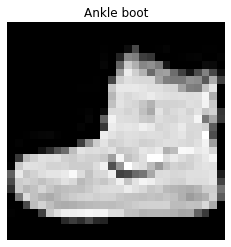

In [31]:
image_name = data_name.iloc[0,1]
image_path = os.path.join(directory+image_name)
image = Image.open(image_path)
plt.imshow(image,cmap='gray', vmin=0, vmax=255)
plt.title(data_name.iloc[0, 0])
plt.axis("off")
plt.show()

In [32]:
class fashionDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        csv_path = os.path.join(root_dir+csv_file)
        self.csv_file = pd.read_csv(csv_path)
        self.transform = transform
    
    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, idx):
        """
            to fetch instances of dataset
            idx :: index
        """
        #Loading the image
        img_name = os.path.join(self.root_dir+self.csv_file.iloc[idx, 1])
        image = Image.open(img_name)
        
        #Loading the label
        label = self.csv_file.iloc[idx, 0]
        
        #Applying transformation
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [33]:
#Creating object of dataset
fdata = fashionDataset(csv_file, directory)

In [34]:
#fetching length of total instances
len(fdata)

101

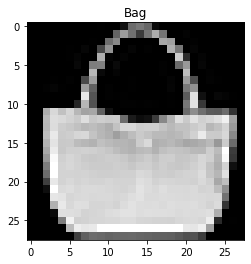

In [35]:
#Accessing a particulare instance of a dataset
img = fdata[100]

plt.imshow(img[0],cmap='gray', vmin=0, vmax=255)
plt.title(img[1])
plt.show()

As part of transform, torchvision provides several built-in transformation for images, like, CenterCrop, ColorJitter, Pad, ToTensor, etc. Click [here](https://pytorch.org/docs/stable/torchvision/transforms.html) for more.

In [36]:
img_transformation = transforms.Compose([transforms.CenterCrop(20), transforms.ToTensor()])
newFData = fashionDataset(csv_file=csv_file, root_dir=directory, transform=img_transformation)

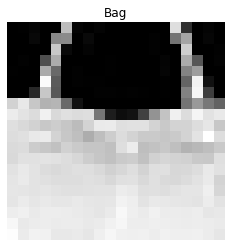

In [37]:
#Accessing a particulare instance of a dataset
img = newFData[100]
show(img, shape=(20,20))

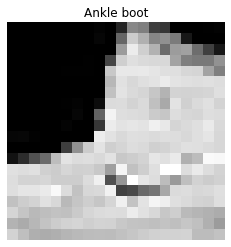

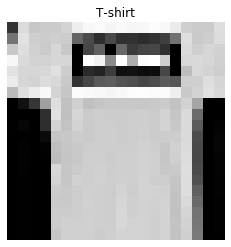

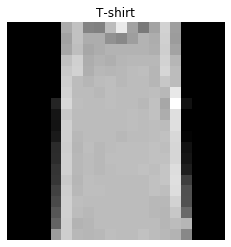

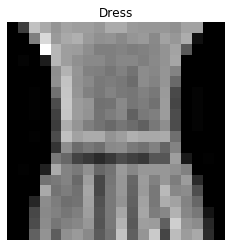

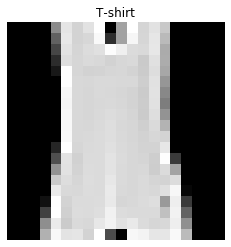

In [38]:
for i in range(5):
    show(newFData[i], shape=(20,20))

### Iterating over dataset using DataLoader
The `Dataset` retrieves our dataset’s `features` and `labels` one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval. `torch.utils.data.DataLoader` wraps an iterable around the `Dataset` to enable easy access to the samples.

Size of a batch features  ::  torch.Size([5, 1, 20, 20])
Size of a batch labels  ::  torch.Size([5, 1, 20, 20])


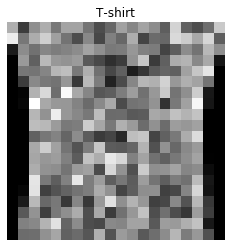

In [48]:
dataloader = DataLoader(newFData, batch_size=5, shuffle=True)

batch_features, batch_labels = next(iter(dataloader))

print(f"Size of a batch features  ::  {batch_features.size()}")
print(f"Size of a batch labels  ::  {batch_features.size()}")
show((batch_features[0], batch_labels[0]), shape=(20,20))

### Iterating over batches using dataloader

Batch Number  :: 0


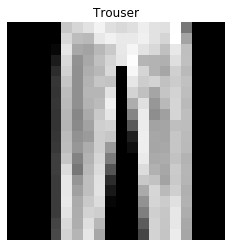

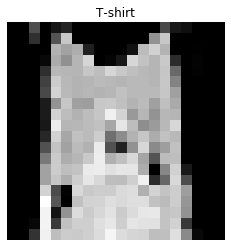

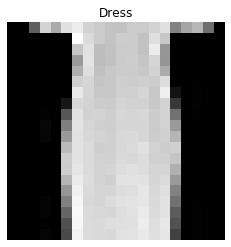

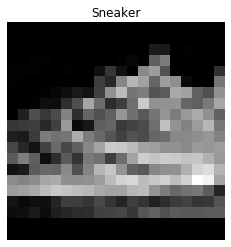

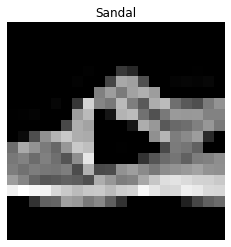

Batch Number  :: 1


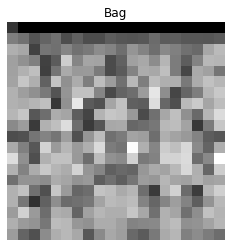

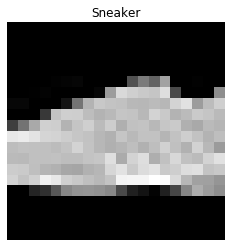

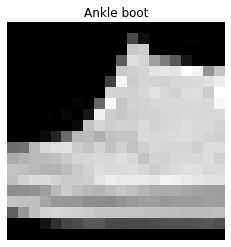

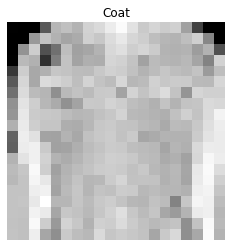

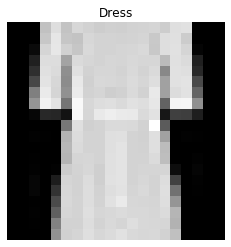

Batch Number  :: 2


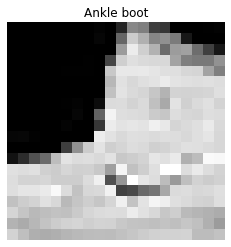

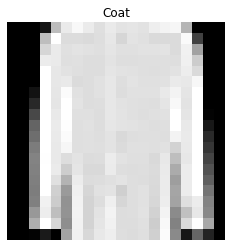

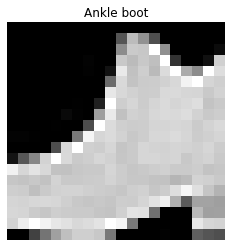

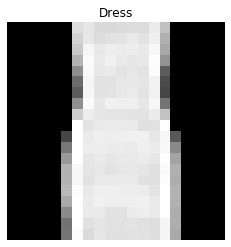

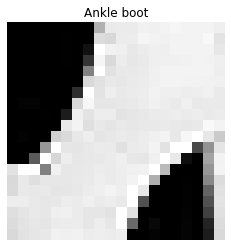

In [49]:
for i_batch, sample_batched in enumerate(dataloader):
    print("Batch Number  :: {}".format(i_batch))
    for i in range(sample_batched[0].shape[0]):
        sample = (sample_batched[0][i], sample_batched[1][i])
        show(sample, shape=(20,20))
    if i_batch == 2:
        break

### text dataset

In [76]:
import json
from nltk.tokenize import word_tokenize

In [329]:
data = json.load(open('./../../data/archive/News_Category_Dataset_v2.json'))
df = pd.DataFrame(data)
label_map = {val: key for key, val in enumerate(df.category.unique())}

MAXLEN = max(df.headline.str.len())

In [372]:
class TextDataset(Dataset):
    def __init__(self, file_name):
        with open(file_name) as infile:
            data = json.load(infile)
        
        data = self.preprocess(data)
        self.data = data
        
    def preprocess(self, data):
        preprocessed = []
        for d in data:
            sentence = d['headline']
            tokens = word_tokenize(sentence)
            # Padding the sentence with largest length
#             if len(tokens) <= MAXLEN:
#                 tokens += ["<PAD>"]* (MAXLEN - len(tokens))
#             elif len(tokens) > MAXLEN:
#                 tokens = tokens[:MAXLEN]
            label = label_map[d['category']]
            preprocessed += [(tokens, label)]
        return preprocessed
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        batch = self.data[idx]
        
        instance={}
        
        tokens = batch[0]
        label = batch[1]
        
        return (tokens, label)

In [373]:
text = TextDataset('./../../data/archive/sample.json')

In [374]:
dataloader = DataLoader(text, batch_size=5)
batch = next(iter(dataloader))

RuntimeError: each element in list of batch should be of equal size

Since the sentences have different length, dataloader is throwing the error. One way is to `pad` the sentence (uncomment the code below `# Padding`) with the largest length (even largest for the batch would work) or use custom `collate_fn` as below.

In simplest sense, the `collate_fn` is a callable/function that processes the batch, the way you want to return from your dataloader. The `batch` argument is a list with all your samples. Used for  padding sequential data to max length of a batch, returning variable sized samples.

In [379]:
def mycollator(batch):
    assert all(x[0] in x for x in batch)
    assert all(x[1] in x for x in batch)
    return [x[0] for x in batch], torch.tensor([x[1] for x in batch])

In [380]:
dataloader = DataLoader(text, batch_size=5, collate_fn=mycollator)
batch = next(iter(dataloader))

In [381]:
batch[0][0], batch[1][0]

(['There',
  'Were',
  '2',
  'Mass',
  'Shootings',
  'In',
  'Texas',
  'Last',
  'Week',
  ',',
  'But',
  'Only',
  '1',
  'On',
  'TV'],
 tensor(0))